In [ ]:
# !pip install segmentation_models
# !pip install tqdm
# !pip install albumentations

In [1]:
import os
import shutil
import json
from PIL import Image, ImageDraw
import numpy as np
from tqdm.notebook import tqdm
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import albumentations as alb
import sys
sys.path.append("..")
# import segmentation_models as sm
from definitions import convert_path
from pathlib import Path
import cv2
from sklearn.utils import class_weight
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import subprocess
import hashlib
from tensorflow.python.keras import layers, models

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print(f'Python version {sys.version}')

TF version: 2.9.0
GPU is available
Python version 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]


### Инициализация констант

In [2]:
MODEL_NAME ='FaceSpoofingBinaryClassification'
IMAGE_SIZE = (224, 224, 3)
IMAGE_SIZE_2 = (224, 224)
DATA_DIR = pathlib.Path(r'D:\Data\Faces\Train')
DEPLOY_DIR = pathlib.Path(r'D:\Data\Faces')
BATCH_SIZE = 32
ALPHA  = 1
EPOCHS = 10
VALIDATION_SPLIT = 0.3
TENSOR_SHAPE = [224, 224]
IMAGE_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp', '.jfif']
print('Done')


Done


### Функции

In [59]:
def get_training_augmentation():
    train_transform = [
        alb.geometric.rotate.RandomRotate90(),
        alb.Affine(
            translate_percent=[-0.1, 0.1],
            rotate=[-3, 3],
            shear=0,
            scale=[1, 1.5],
#             cval=0,
#             cval_mask=0,
            mode=2,
            fit_output=False,
            p=1),
    ]
    return alb.Compose(train_transform)


def load_image(image_path, label):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    return image, label


def aug_func(image):

    augmented = train_transform(image=image)
    pr_img = augmented['image']
    pr_img = tf.cast(pr_img, tf.float32)
    # pr_img = tf.image.resize(pr_img, size=TENSOR_SHAPE)
    try:
        pr_img = tf.image.resize(pr_img, size=TENSOR_SHAPE)
    except:
        # pr_img = pr_img
        print(image.shape.as_list())

    return pr_img


def preprocess_train_image(image, label):

    preprocessed = tf.numpy_function(aug_func, [image,], Tout=tf.float32)

    preprocessed.set_shape(TENSOR_SHAPE + [3])

    return preprocessed, label


def aug_val_fn(image):

    aug_img = tf.cast(image, tf.float32)
    # aug_img = tf.image.resize(aug_img, size=TENSOR_SHAPE)
    try:
        aug_img = tf.image.resize(aug_img, size=TENSOR_SHAPE)
    except:
        print(image.shape.as_list())

    # aug_img = tf.image.resize(aug_img, size=TENSOR_SHAPE)

    return aug_img


def preprocess_val_image(image, label):

    preprocessed = tf.numpy_function(func=aug_val_fn, inp=[image,], Tout=tf.float32)

    preprocessed.set_shape(TENSOR_SHAPE + [3])

    return preprocessed, label


train_transform = get_training_augmentation()
print('Functions are created')

Functions are created


In [60]:
def get_datasets(data_dir):
    all_images_paths = np.array([str(path) for path in list(data_dir.glob('**/*')) if path.suffix in IMAGE_FORMATS])
    all_image_paths = list(data_dir.glob('**/*'))

    labels = np.array([1 if path.match('Real/*/*') else 0 for path in all_image_paths if path.suffix.lower() in IMAGE_FORMATS])
    # print()
    # ds = tf.data.Dataset.from_tensor_slices((all_images_paths, labels))

    path_ds = tf.data.Dataset.from_tensor_slices(all_images_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))

    dataset_size=len(ds)
    train_size = int((1-VALIDATION_SPLIT) * dataset_size)

    full_dataset = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=True)
    train_dataset = full_dataset.take(train_size)
    val_dataset = full_dataset.skip(train_size)

    return train_dataset, val_dataset, labels


train_ds, val_ds, train_labels = get_datasets(DATA_DIR)
size_train_ds = len(train_ds)
size_val_ds = len(val_ds)
train_ds = train_ds.shuffle(buffer_size=len(train_ds), reshuffle_each_iteration=True)
train_ds = train_ds.map(load_image, num_parallel_calls=-1)
train_ds = train_ds.map(preprocess_train_image, num_parallel_calls=-1)
train_ds = train_ds.batch(32).prefetch(-1).repeat()
#
val_ds = val_ds.shuffle(buffer_size=len(val_ds), reshuffle_each_iteration=True)
val_ds = val_ds.map(load_image, num_parallel_calls=-1)
val_ds = val_ds.map(preprocess_val_image, num_parallel_calls=-1)
val_ds = val_ds.batch(32).prefetch(-1)
#

print(size_train_ds, size_val_ds, size_train_ds+size_val_ds)
print('Datasets are created')


392437 168188 560625
Datasets are created


### Смотрим что получилось

In [ ]:
im_batch, lbl_batch = next(iter(train_ds))

test_image = im_batch[0].numpy()

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i, grid in enumerate(zip(grid, im_batch)):
    ax, im = grid
    ax.imshow(im / 255.0)
    ax.set_title('Fake' if lbl_batch[i] == 0 else 'Real', fontdict=None, loc='center', color = "k")

plt.show()

In [ ]:
im_batch, lbl_batch = next(iter(val_ds))

test_image = im_batch[0].numpy()

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i, grid in enumerate(zip(grid, im_batch)):
    ax, im = grid
    ax.imshow(im / 255.0)
    ax.set_title('Fake' if lbl_batch[i] == 0 else 'Real', fontdict=None, loc='center', color = "k")

plt.show()

In [63]:
# print(train_labels)
# lables
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
           classes=[0, 1],
           y=train_labels)
print(f'Веса отличааются в {class_weights.max()/class_weights.min()} раз!!!')

c_w = {class_num: weight for class_num, weight in enumerate(class_weights)}

Веса отличааются в 3.1940974040547614 раз!!!


### Собираем модель

In [64]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), alpha=0.35, weights='imagenet', classes=1, classifier_activation='sigmoid', include_top=False) # was alpha=0.35
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
norm = tf.keras.layers.Lambda(lambda x: x / 255, name='division_255')(inputs)
x = base_model(norm, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(512)(x)
# x = tf.keras.layers.Dense(256)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(loss=tf.keras.losses.BinaryCrossentropy(),  #(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # was learning_rate=1e-3
                  metrics=[tf.keras.metrics.binary_accuracy, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print('Done')

Done


In [65]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 division_255 (Lambda)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_0.35_224 (Funct  (None, 7, 7, 1280)       410208    
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 411,489
Trainable params: 1,281
Non-trainable

In [66]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         min_delta=0.000001,
                                         cooldown=0,
                                         min_lr=0.0000001)

chk_path = convert_path(DEPLOY_DIR.joinpath('checkpoint', 'ckpt.h5'))

checkpointer = tf.keras.callbacks.ModelCheckpoint(chk_path, save_best_only=True, verbose=1)

stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.00001, verbose=1)

print('Done')

Done


In [67]:
EPOCHS = 100
print(f'Epochs = {EPOCHS}')

Epochs = 100


In [17]:
model = tf.keras.models.load_model(r'D:\Data\Faces\checkpoint\ckpt.h5')


### Учим только классификационный слой

In [68]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    steps_per_epoch=2100,  # was 300
#                     validation_steps=150,
                    epochs=EPOCHS,
                    verbose=1,
                    class_weight=c_w,
                    callbacks=[
                        reduce_learning_rate, 
                        stopper,
                        checkpointer
                    ])
print('Done')

Epoch 1/100
2100/2100 [==============================] - ETA: 0s - loss: 0.3027 - binary_accuracy: 0.8773 - recall_8: 0.8729 - precision_8: 0.6922
Epoch 1: val_loss improved from inf to 0.36233, saving model to D:\Data\Faces\checkpoint\ckpt.h5
2100/2100 [==============================] - 960s 455ms/step - loss: 0.3027 - binary_accuracy: 0.8773 - recall_8: 0.8729 - precision_8: 0.6922 - val_loss: 0.3623 - val_binary_accuracy: 0.8342 - val_recall_8: 0.9520 - val_precision_8: 0.5963 - lr: 0.0010
Epoch 2/100
2100/2100 [==============================] - ETA: 0s - loss: 0.2471 - binary_accuracy: 0.9012 - recall_8: 0.8983 - precision_8: 0.7408
Epoch 2: val_loss improved from 0.36233 to 0.33283, saving model to D:\Data\Faces\checkpoint\ckpt.h5
2100/2100 [==============================] - 906s 432ms/step - loss: 0.2471 - binary_accuracy: 0.9012 - recall_8: 0.8983 - precision_8: 0.7408 - val_loss: 0.3328 - val_binary_accuracy: 0.8522 - val_recall_8: 0.9510 - val_precision_8: 0.6244 - lr: 0.0010


In [74]:
test_image_real = load_image(r'D:\Models\MyFaceSpoofingBig\TestCases\Data\real_1.jpg',1)
test_image_real = preprocess_val_image(test_image_real[0] , 1)
test_image_fake = load_image(r'D:\Models\MyFaceSpoofingBig\TestCases\Data\fake_1.jpg',1)
test_image_fake = preprocess_val_image(test_image_fake[0] , 1)
result = model.predict(tf.expand_dims(test_image_real[0],axis=0))
print(result)
result = model.predict(tf.expand_dims(test_image_fake[0],axis=0))
print(result)
# batch = next(iter(val_ds))
# batch[0]

1/1 [==============================] - 1s 1s/step
[[0.9940116]]
1/1 [==============================] - 0s 25ms/step
[[0.00827301]]


In [73]:
path = DEPLOY_DIR.joinpath('release_face_spoofing_mn2_a35_v6')
path_h5 = DEPLOY_DIR.joinpath('release_face_spoofing_mn2_a35_v6.h5')
model.save(path)
model.save(path_h5)
print('Models saved!')

INFO:tensorflow:Assets written to: D:\Data\Faces\release_face_spoofing_mn2_a35_v6\assets


INFO:tensorflow:Assets written to: D:\Data\Faces\release_face_spoofing_mn2_a35_v6\assets


Models saved!


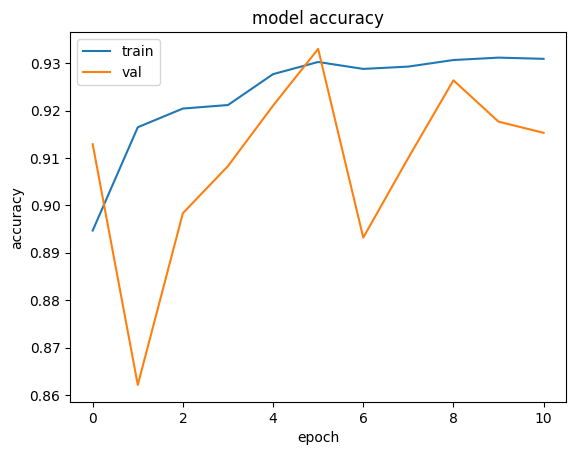

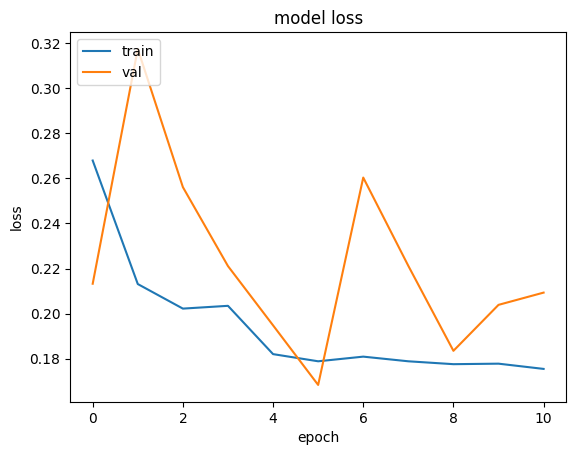

KeyError: 'recall'

In [45]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Размораживаем основу и доучиваем

In [70]:
base_model.trainable = True
fine_tune_at = len(base_model.layers)
print(fine_tune_at)
for layer in base_model.layers[:fine_tune_at]:
# [:fine_tune_at]:
    layer.trainable =  True

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),  #(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # was learning_rate=1e-3
                  metrics=[tf.keras.metrics.binary_accuracy, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print('Done')

154
Done


In [71]:
history = model.fit(train_ds,
                    validation_data=val_ds, 
                    steps_per_epoch=2100,  # was 200
#                     validation_steps=150,
                    epochs=100,
                    class_weight=c_w,
                    verbose=1, 
                    callbacks=[
                        reduce_learning_rate, 
                        stopper,
                        checkpointer
                    ])

Epoch 1/100
2100/2100 [==============================] - ETA: 0s - loss: 0.1857 - binary_accuracy: 0.9279 - recall_9: 0.9258 - precision_9: 0.8022
Epoch 1: val_loss did not improve from 0.22767
2100/2100 [==============================] - 1042s 493ms/step - loss: 0.1857 - binary_accuracy: 0.9279 - recall_9: 0.9258 - precision_9: 0.8022 - val_loss: 0.2519 - val_binary_accuracy: 0.8992 - val_recall_9: 0.9802 - val_precision_9: 0.7089 - lr: 1.0000e-05
Epoch 2/100
2100/2100 [==============================] - ETA: 0s - loss: 0.1481 - binary_accuracy: 0.9435 - recall_9: 0.9395 - precision_9: 0.8423
Epoch 2: val_loss improved from 0.22767 to 0.16115, saving model to D:\Data\Faces\checkpoint\ckpt.h5
2100/2100 [==============================] - 1032s 491ms/step - loss: 0.1481 - binary_accuracy: 0.9435 - recall_9: 0.9395 - precision_9: 0.8423 - val_loss: 0.1611 - val_binary_accuracy: 0.9383 - val_recall_9: 0.9756 - val_precision_9: 0.8067 - lr: 1.0000e-05
Epoch 3/100
2100/2100 [=================

### Смотрим что получилось

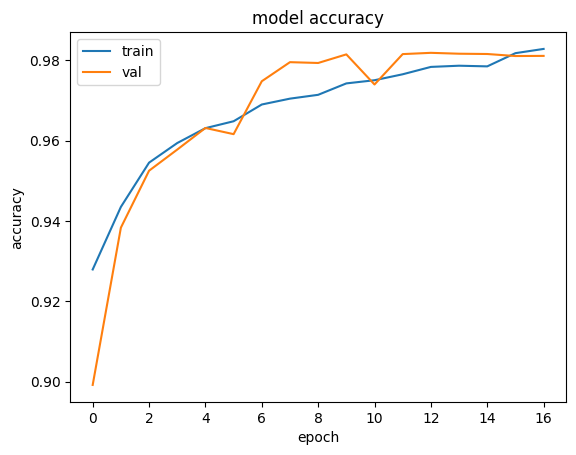

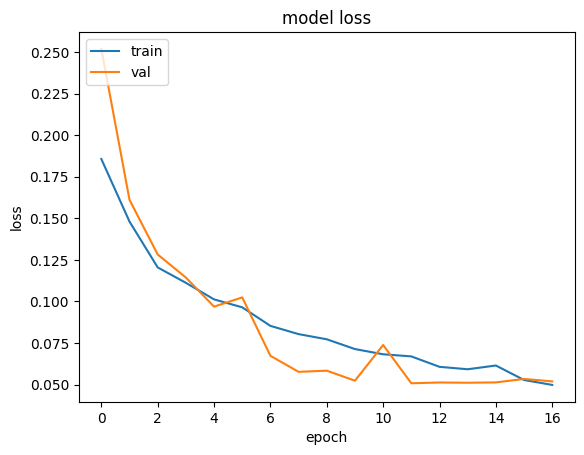

KeyError: 'recall'

In [72]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Грузим модель

In [52]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 division_255 (Lambda)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 512)               655872    
                                                                 
 dense_6 (Dense)             (None, 256)               1313

### Model Pruning

In [75]:
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
print(model.summary())
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=2100)
}
mobilenet_for_pruning = tf.keras.models.clone_model(model.layers[2])
mobilenet_for_pruning.set_weights(model.layers[2].get_weights())
mobilenet_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(mobilenet_for_pruning, **pruning_params)

inputs = tf.keras.Input(shape=(224, 224, 3))
# norm = inputs / 255.0
norm = tf.keras.layers.Lambda(lambda x: x / 255, name='division_255')(inputs)
x = mobilenet_for_pruning(norm, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(512)(x)
# x = tf.keras.layers.Dense(256)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_prune = tf.keras.Model(inputs, outputs)

model_prune.compile(loss=tf.keras.losses.BinaryCrossentropy(),  #(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # was learning_rate=1e-3
                  metrics=[tf.keras.metrics.binary_accuracy, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print('Done')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 division_255 (Lambda)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_0.35_224 (Funct  (None, 7, 7, 1280)       410208    
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 411,489
Trainable params: 397,409
Non-trainab

In [54]:
model_prune.compile(loss=tf.keras.losses.BinaryCrossentropy(),  #(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # was learning_rate=1e-3
                  metrics=[tf.keras.metrics.binary_accuracy, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
print('Done')

Done


In [76]:
history = model_prune.fit(train_ds, validation_data=val_ds, steps_per_epoch=2100,
                  batch_size=batch_size, epochs=50,  class_weight=c_w,
                  callbacks=[
                        reduce_learning_rate,
                        tfmot.sparsity.keras.UpdatePruningStep(),
                        stopper,
                        checkpointer
                    ])

Epoch 1/50
2100/2100 [==============================] - ETA: 0s - loss: 0.4049 - binary_accuracy: 0.8052 - recall_10: 0.8372 - precision_10: 0.5594
Epoch 1: val_loss did not improve from 0.05082
2100/2100 [==============================] - 1328s 617ms/step - loss: 0.4049 - binary_accuracy: 0.8052 - recall_10: 0.8372 - precision_10: 0.5594 - val_loss: 0.3379 - val_binary_accuracy: 0.8600 - val_recall_10: 0.8246 - val_precision_10: 0.6674 - lr: 1.0000e-05
Epoch 2/50
2100/2100 [==============================] - ETA: 0s - loss: 0.3134 - binary_accuracy: 0.8763 - recall_10: 0.8507 - precision_10: 0.6991
Epoch 2: val_loss did not improve from 0.05082
2100/2100 [==============================] - 1258s 599ms/step - loss: 0.3134 - binary_accuracy: 0.8763 - recall_10: 0.8507 - precision_10: 0.6991 - val_loss: 0.2870 - val_binary_accuracy: 0.8849 - val_recall_10: 0.8615 - val_precision_10: 0.7136 - lr: 1.0000e-05
Epoch 3/50
2100/2100 [==============================] - ETA: 0s - loss: 0.2818 - bin

In [77]:
import tensorflow_model_optimization as tfmot
for layer in model_prune.layers:
    layer.trainable = False
model_for_export = tfmot.sparsity.keras.strip_pruning(model_prune)

path_h5 = DEPLOY_DIR.joinpath('release_face_spoofing_mn2_a35_v5_pruned.h5')
model_for_export.save(path_h5, include_optimizer=False)
path = DEPLOY_DIR.joinpath('release_face_spoofing_mn2_a35_v5_pruned')
model_for_export.save(path, include_optimizer=False)
print('Model saved!')

INFO:tensorflow:Assets written to: D:\Data\Faces\release_face_spoofing_mn2_a35_v5_pruned\assets


INFO:tensorflow:Assets written to: D:\Data\Faces\release_face_spoofing_mn2_a35_v5_pruned\assets


Model saved!


In [78]:
test_image_real = load_image(r'D:\Models\MyFaceSpoofingBig\TestCases\Data\real_1.jpg',1)
test_image_real = preprocess_val_image(test_image_real[0] , 1)
test_image_fake = load_image(r'D:\Models\MyFaceSpoofingBig\TestCases\Data\fake_1.jpg',1)
test_image_fake = preprocess_val_image(test_image_fake[0] , 1)
result = model_for_export.predict(tf.expand_dims(test_image_real[0],axis=0))
print(result)
result = model_for_export.predict(tf.expand_dims(test_image_fake[0],axis=0))
print(result)

1/1 [==============================] - 1s 1s/step
[[0.9978968]]
1/1 [==============================] - 0s 23ms/step
[[0.13479795]]
